# Import the required libraries and dataset

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
pd.set_option('display.mpl_style', 'default') 
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60) 


/Users/bhargav/anaconda/envs/gl-env/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2885: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
# import data
products = pd.read_csv('amazon_baby_subset.csv')
products.head(10)['name']

0    Stop Pacifier Sucking without tears with Thumb...
1      Nature's Lullabies Second Year Sticker Calendar
2      Nature's Lullabies Second Year Sticker Calendar
3                          Lamaze Peekaboo, I Love You
4    SoftPlay Peek-A-Boo Where's Elmo A Children's ...
5                            Our Baby Girl Memory Book
6    Hunnt&reg; Falling Flowers and Birds Kids Nurs...
7    Blessed By Pope Benedict XVI Divine Mercy Full...
8    Cloth Diaper Pins Stainless Steel Traditional ...
9    Cloth Diaper Pins Stainless Steel Traditional ...
Name: name, dtype: object

 1    26579
-1    26493
Name: sentiment, dtype: int64


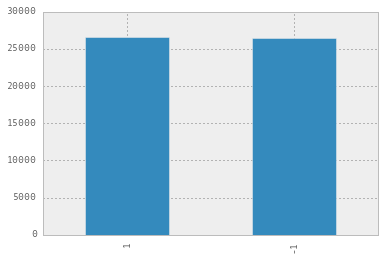

In [3]:
sentiment_count = products['sentiment'].value_counts()
print(sentiment_count)
sentiment_count.plot(kind='bar')

# Load important words and clean the data

In [4]:
important_words = pd.read_json('important_words.json')
# Convert to list to get the Bag-of-Words count
important_words = list(important_words.astype(str).values.flatten())

In [5]:
products = products.fillna({'review':''})  # fill in N/A's in the review column

## Remove punctuation from all the reiews 

In [6]:
def remove_punctuation(text):
    import string
    return text.translate(None, string.punctuation)

products['review_clean'] = products['review'].apply(remove_punctuation)

## Compute Bag-of-Word count

In [7]:
# This is slow, could explore different ways to do this. Probably this is the best.
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

**Quiz Question.** How many reviews contain the word perfect?

In [8]:
products['contains_perfect'] = products['perfect'].apply(lambda i : 1 if i >= 1 else 0)
perfect_count = products['contains_perfect'].sum()
print 'Number of reviews that contain word perfect: ', perfect_count

Number of reviews that contain word perfect:  2955


# Convert data frame to multi-dimensional array

In [9]:
def get_numpy_data(dataframe, features, label):
    dataframe['constant'] = 1
    features = ['constant'] + features
    features_frame = dataframe[features]
    feature_matrix = features_frame.as_matrix()
    label_sarray = dataframe[label]
    label_array = label_sarray.as_matrix()
    return(feature_matrix, label_array)

(feature_matrix, sentiment) = get_numpy_data(products, important_words, 'sentiment')

**Quiz Question:** How many features are there in the feature_matrix?

In [10]:
print 'Number of features are: ', feature_matrix.shape[-1]

Number of features are:  194


# Estimating conditional probability with link function

In [11]:
'''
produces probablistic estimate for P(y_i = +1 | x_i, w).
estimate ranges between 0 and 1.
'''
def predict_probability(feature_matrix, coefficients):
    # Take dot product of feature_matrix and coefficients  
    score = np.dot(feature_matrix, coefficients)
    
    # Compute P(y_i = +1 | x_i, w) using the link function
    predictions = np.reciprocal(1 + np.exp(-score))
    
    # return predictions
    return predictions

In [12]:
# Checkpoint
dummy_feature_matrix = np.array([[1.,2.,3.], [1.,-1.,-1]])
dummy_coefficients = np.array([1., 3., -1.])

correct_scores      = np.array( [ 1.*1. + 2.*3. + 3.*(-1.),          1.*1. + (-1.)*3. + (-1.)*(-1.) ] )
correct_predictions = np.array( [ 1./(1+np.exp(-correct_scores[0])), 1./(1+np.exp(-correct_scores[1])) ] )

print 'The following outputs must match '
print '------------------------------------------------'
print 'correct_predictions           =', correct_predictions
print 'output of predict_probability =', predict_probability(dummy_feature_matrix, dummy_coefficients)

The following outputs must match 
------------------------------------------------
correct_predictions           = [ 0.98201379  0.26894142]
output of predict_probability = [ 0.98201379  0.26894142]


# Compute derivative of log likelihood with respect to a single coefficient

In [13]:
def feature_derivative(errors, feature):     
    # Compute the dot product of errors and feature. feature is a vector and not a matrix.
    derivative = np.dot(feature, errors)
        # Return the derivative
    return derivative

def compute_log_likelihood(feature_matrix, sentiment, coefficients):
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    lp = np.sum((indicator-1)*scores - np.log(1. + np.exp(-scores)))
    return lp

In [14]:
# Checkpoint
dummy_feature_matrix = np.array([[1.,2.,3.], [1.,-1.,-1]])
dummy_coefficients = np.array([1., 3., -1.])
dummy_sentiment = np.array([-1, 1])

correct_indicators  = np.array( [ -1==+1,                                       1==+1 ] )
correct_scores      = np.array( [ 1.*1. + 2.*3. + 3.*(-1.),                     1.*1. + (-1.)*3. + (-1.)*(-1.) ] )
correct_first_term  = np.array( [ (correct_indicators[0]-1)*correct_scores[0],  (correct_indicators[1]-1)*correct_scores[1] ] )
correct_second_term = np.array( [ np.log(1. + np.exp(-correct_scores[0])),      np.log(1. + np.exp(-correct_scores[1])) ] )

correct_ll          =      sum( [ correct_first_term[0]-correct_second_term[0], correct_first_term[1]-correct_second_term[1] ] ) 

print 'The following outputs must match '
print '------------------------------------------------'
print 'correct_log_likelihood           =', correct_ll
print 'output of compute_log_likelihood =', compute_log_likelihood(dummy_feature_matrix, dummy_sentiment, dummy_coefficients)

The following outputs must match 
------------------------------------------------
correct_log_likelihood           = -5.33141161544
output of compute_log_likelihood = -5.33141161544


In [15]:
from math import sqrt
def logistic_regression(feature_matrix, sentiment, initial_coefficients, step_size, max_iter):
    coefficients = np.array(initial_coefficients) # make sure it's a numpy array
    for itr in xrange(max_iter):
        # Predict P(y_i = +1|x_1,w) using your predict_probability() function
        predictions = predict_probability(feature_matrix, coefficients)

        # Compute indicator value for (y_i = +1)
        indicator = (sentiment==+1)

        # Compute the errors as indicator - predictions
        errors = indicator - predictions

        for j in xrange(len(coefficients)): # loop over each coefficient
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j]
            # compute the derivative for coefficients[j]. Save it in a variable called derivative
            derivative = feature_derivative(errors, feature_matrix[:,j])

            # add the step size times the derivative to the current coefficient
            coefficients[j] += step_size*derivative

        # Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood(feature_matrix, sentiment, coefficients)
            print 'iteration %*d: log likelihood of observed labels = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, lp)
    print 'Training Complete using Logitic Regression'
    return coefficients

In [16]:
coefficients = logistic_regression(feature_matrix, sentiment, initial_coefficients=np.zeros(194),
                                   step_size=1e-7, max_iter=301)

iteration   0: log likelihood of observed labels = -36780.91768478
iteration   1: log likelihood of observed labels = -36775.13434712
iteration   2: log likelihood of observed labels = -36769.35713564
iteration   3: log likelihood of observed labels = -36763.58603240
iteration   4: log likelihood of observed labels = -36757.82101962
iteration   5: log likelihood of observed labels = -36752.06207964
iteration   6: log likelihood of observed labels = -36746.30919497
iteration   7: log likelihood of observed labels = -36740.56234821
iteration   8: log likelihood of observed labels = -36734.82152213
iteration   9: log likelihood of observed labels = -36729.08669961
iteration  10: log likelihood of observed labels = -36723.35786366
iteration  11: log likelihood of observed labels = -36717.63499744
iteration  12: log likelihood of observed labels = -36711.91808422
iteration  13: log likelihood of observed labels = -36706.20710739
iteration  14: log likelihood of observed labels = -36700.5020

## Measuring accuracy

In [17]:
# Predictions
score = np.dot(feature_matrix, coefficients)
yHat = np.less_equal(0, score).astype(int)
yHat[(np.where(yHat == 0))] = -1

**Quiz question:** How many reviews are predicted to have positive sentiment?

In [18]:
print 'Number of positive sentiment prediction:' , np.count_nonzero(yHat == 1)

Number of positive sentiment prediction: 25126


**Quiz question:** What is the accuracy of the model on predictions made above?

In [19]:
num_datapoints = len(yHat)
correct_pred = np.sum(yHat == sentiment)
num_mistakes = num_datapoints - correct_pred
accuracy = float(correct_pred)/num_datapoints
print "-----------------------------------------------------"
print '# Reviews correctly classified   =', len(products) - num_mistakes
print '# Reviews incorrectly classified =', num_mistakes
print '# Reviews total                  =', len(products)
print "-----------------------------------------------------"
print 'Accuracy = %.2f' % accuracy

-----------------------------------------------------
# Reviews correctly classified   = 39903
# Reviews incorrectly classified = 13169
# Reviews total                  = 53072
-----------------------------------------------------
Accuracy = 0.75


## Which words contribute most to positive & negative sentiments

In [20]:
coefficients = list(coefficients[1:]) # exclude intercept
word_coefficient_tuples = [(word, coefficient) for word, coefficient in zip(important_words, coefficients)]
word_coefficient_tuples = sorted(word_coefficient_tuples, key=lambda x:x[1], reverse=True)

**Quiz question:** Which word is not present in the top 10 "most positive" words?

In [21]:
word_coefficient_tuples[0:10]

[('great', 0.066546084170457695),
 ('love', 0.065890762922123258),
 ('easy', 0.06479458680257838),
 ('little', 0.045435626308421365),
 ('loves', 0.044976401394906038),
 ('well', 0.030135001092107077),
 ('perfect', 0.029739937104968462),
 ('old', 0.020077541034775378),
 ('nice', 0.018408707995268992),
 ('daughter', 0.017703199905701694)]

**Quiz question:** Which word is not present in the top 10 "most negative" words?

In [22]:
word_coefficient_tuples[-10:]

[('monitor', -0.024482100545891717),
 ('return', -0.026592778462247283),
 ('back', -0.027742697230661334),
 ('get', -0.028711552980192574),
 ('disappointed', -0.028978976142317068),
 ('even', -0.030051249236035804),
 ('work', -0.03306951529475273),
 ('money', -0.038982037286487116),
 ('product', -0.041511033392108904),
 ('would', -0.053860148445203142)]